Ghi chú triển khai — Team AI:

1) Trước khi chạy FULL extraction:
   - Test encode 10 ảnh (Cell 9) => OK.
   - Kiểm tra device, disk, memory.

2) Fine-tune:
   - Cell 7 chạy EPOCHS nhỏ (1–3) để test; theo dõi val_acc.
   - Nếu muốn metric embedding tốt hơn cho retrieval, sau khi có baseline classifier fine-tune, chuyển qua training bằng TripletLoss hoặc SupCon.

3) Extract toàn bộ:
   - Cell 10 sẽ tạo thư mục /content/emb_chunks với nhiều file parts (embeddings_part_0.pkl, ...).
   - Sau khi hoàn thành, có thể merge hoặc backend ingest trực tiếp.

4) Backend phối hợp:
   - Team Backend dùng script ingest_to_mongo.py để đưa embeddings + metadata vào MongoDB Atlas.
   - Backend cần tạo vector index HNSW (dims=512, similarity=cosine).
   - Backend triển khai endpoint /search_similar nhận embedding từ AI service, gọi MongoDB $vectorSearch -> trả top-K.

5) MLOps / Ops:
   - Containerize inference service (Dockerfile).
   - Đặt job incremental: khi có product mới, chạy nhỏ để encode 1 item và upsert vào DB.
   - Giám sát latency: mục tiêu encode endpoint <= 200ms (GPU) + query DB <= 100ms.

6) Thông số tài nguyên:
   - Với T4 (15GB): encode toàn bộ ảnh bằng batch_size=64 ~ vài chục phút; fine-tune cần điều chỉnh batch smaller.

Kết luận: Notebook này cho team AI đầy đủ công cụ để fine-tune (classification baseline), tạo embedding 512-D, xuất chunked files, cung cấp FastAPI mẫu, và script ingest cho Backend. Nếu muốn mình bổ sung TripletLoss training script, mình sẽ thêm tiếp.


In [ ]:
# ========== CELL 1 - ENVIRONMENT & IMPORTS ==========
import os, sys, time, json, random, math, pickle
from collections import Counter, defaultdict

import numpy as np
import pandas as pd
from PIL import Image
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import models, transforms
from torch.utils.data import Dataset, DataLoader, Subset

print("Torch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())
if torch.cuda.is_available():
    print("Device name:", torch.cuda.get_device_name(0))

Torch version: 2.8.0+cu126
CUDA available: True
Device name: Tesla T4


In [ ]:
# -------------------- Cell 2: Kaggle setup (run in Colab) --------------------
# Upload kaggle.json (API token) when prompted.
# Shell commands (run in separate notebook cell):
from google.colab import files
files.upload() # upload kaggle.json
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d enisteper1/polyvore-outfit-dataset -p /content --unzip


# After running above, dataset will be available at /content/polyvore-outfit-dataset/polyvore_outfits

Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/enisteper1/polyvore-outfit-dataset
License(s): other
100% 2.30G/2.30G [00:26<00:00, 287MB/s]
100% 2.30G/2.30G [00:26<00:00, 94.6MB/s]


In [ ]:
# ========== CELL 3 - PATHS, LOAD METADATA, SANITY CHECK ==========
DATA_PATH = '/content/polyvore_outfits'   # chỉnh nếu khác
IMAGES_DIR = os.path.join(DATA_PATH, 'images')
METADATA_PATH = os.path.join(DATA_PATH, 'polyvore_item_metadata.json')

assert os.path.exists(DATA_PATH), f"DATA_PATH not found: {DATA_PATH}"
assert os.path.exists(IMAGES_DIR), f"IMAGES_DIR not found: {IMAGES_DIR}"
assert os.path.exists(METADATA_PATH), f"METADATA_PATH not found: {METADATA_PATH}"

with open(METADATA_PATH, 'r') as f:
    item_metadata = json.load(f)

print(f"Loaded metadata: {len(item_metadata)} items")
# xem thống kê categories
categories = [v.get('semantic_category','Unknown') for v in item_metadata.values()]
cat_counts = Counter(categories)
print("Top categories (sample):", cat_counts.most_common(20))

# map category -> idx
unique_cats = sorted(list(set(categories)))
cat2idx = {c:i for i,c in enumerate(unique_cats)}
idx2cat = {i:c for c,i in cat2idx.items()}
print("Num classes:", len(cat2idx))

Loaded metadata: 251008 items
Top categories (sample): [('shoes', 44850), ('jewellery', 41414), ('bags', 40717), ('tops', 32998), ('bottoms', 27670), ('all-body', 18478), ('outerwear', 17065), ('sunglasses', 9874), ('accessories', 6973), ('hats', 6071), ('scarves', 4898)]
Num classes: 11


In [ ]:
!pip install faiss-cpu --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 74.8 MB/s eta 0:00:00


In [ ]:
# ========== CELL 4 - TRANSFORMS & DATASET ==========
IMG_SIZE = 224

train_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.8,1.0)),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(0.12,0.12,0.12),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

class FashionCategoryDataset(Dataset):
    """
    Dataset trả về: (item_id (str), img_tensor (C,H,W), label (int))
    """
    def __init__(self, img_dir, metadata_dict, cat2idx, transform=None, ext_list=['.jpg','.jpeg','.png']):
        self.img_dir = img_dir
        self.meta = metadata_dict
        self.ids = list(metadata_dict.keys())
        self.cat2idx = cat2idx
        self.transform = transform
        self.ext_list = ext_list

    def _find_image_path(self, item_id):
        for e in self.ext_list:
            p = os.path.join(self.img_dir, f"{item_id}{e}")
            if os.path.exists(p):
                return p
        # fallback: file startswith
        for fn in os.listdir(self.img_dir):
            if fn.startswith(item_id):
                return os.path.join(self.img_dir, fn)
        return None

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        item_id = self.ids[idx]
        img_path = self._find_image_path(item_id)
        if img_path is None:
            img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), (255,255,255))
        else:
            try:
                img = Image.open(img_path).convert('RGB')
            except:
                img = Image.new('RGB', (IMG_SIZE, IMG_SIZE), (255,255,255))

        img_tensor = self.transform(img) if self.transform else transforms.ToTensor()(img)
        cat = self.meta[item_id].get('semantic_category','Unknown')
        label = self.cat2idx.get(cat, 0)
        return item_id, img_tensor, label

# Sanity quick test: load 5 samples
ds = FashionCategoryDataset(IMAGES_DIR, item_metadata, cat2idx, transform=val_transform)
print("Dataset len:", len(ds))
for i in range(3):
    iid, t, lbl = ds[i]
    print(iid, t.shape, lbl, idx2cat[lbl])

Dataset len: 251008
211990161 torch.Size([3, 224, 224]) 10 tops
183179503 torch.Size([3, 224, 224]) 3 bottoms
152771755 torch.Size([3, 224, 224]) 5 jewellery


In [ ]:
print("Số lượng nhãn:", len(cat2idx))
print("Mapping category → index:")
for k,v in cat2idx.items():
    print(f"{k:15s} → {v}")

Số lượng nhãn: 11
Mapping category → index:
accessories     → 0
all-body        → 1
bags            → 2
bottoms         → 3
hats            → 4
jewellery       → 5
outerwear       → 6
scarves         → 7
shoes           → 8
sunglasses      → 9
tops            → 10


In [ ]:
# ========== CELL 5 - SIMPLE SPLIT ==========
from sklearn.model_selection import train_test_split

ids = list(item_metadata.keys())
train_ids, val_ids = train_test_split(ids, test_size=0.02, random_state=42)  # 2% làm val (khoảng 5k ảnh)

# Subset wrapper
def make_subset_by_ids(base_dataset, ids_subset):
    id_to_idx = {iid:i for i,iid in enumerate(base_dataset.ids)}
    indices = [id_to_idx[iid] for iid in ids_subset if iid in id_to_idx]
    return Subset(base_dataset, indices)

base_train = FashionCategoryDataset(IMAGES_DIR, item_metadata, cat2idx, transform=train_transform)
base_val = FashionCategoryDataset(IMAGES_DIR, item_metadata, cat2idx, transform=val_transform)
train_ds = make_subset_by_ids(base_train, train_ids)
val_ds = make_subset_by_ids(base_val, val_ids)

print("Train len:", len(train_ds), "Val len:", len(val_ds))

Train len: 245987 Val len: 5021


In [ ]:
# ========== CELL 6 - MODEL (Resnet 50 backbone + proj 512) ==========
def get_finetune_model(out_dim=512, pretrained=True, device=None, num_classes=None):
    resnet = models.resnet50(pretrained=pretrained)
    modules = list(resnet.children())[:-1]   # giữ đến avgpool
    backbone = nn.Sequential(*modules)

    class FineTuneModel(nn.Module):
        def __init__(self, backbone, out_dim, num_classes=None):
            super().__init__()
            self.backbone = backbone
            self.proj = nn.Linear(2048, out_dim)
            self.classifier = nn.Linear(out_dim, num_classes) if num_classes else None

        def forward(self, x):
            x = self.backbone(x)          # (B,2048,1,1)
            x = x.view(x.size(0), -1)     # (B,2048)
            emb = self.proj(x)            # (B,out_dim)
            emb = F.normalize(emb, p=2, dim=1)
            if self.classifier is not None:
                logits = self.classifier(emb)
                return emb, logits
            return emb, None

    model = FineTuneModel(backbone, out_dim, num_classes=num_classes)
    # Freeze all then unfreeze layer4 + proj + classifier
    for name, p in model.named_parameters():
        p.requires_grad = False
    # unfreeze layer4 (resnet layer4 corresponds to last conv block)
    for n, p in model.backbone.named_parameters():
        if n.startswith('7') or 'layer4' in n:  # conservative
            p.requires_grad = True
    # unfreeze proj & classifier
    for p in model.proj.parameters(): p.requires_grad = True
    if model.classifier is not None:
        for p in model.classifier.parameters(): p.requires_grad = True

    if device:
        model = model.to(device)
    return model

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = get_finetune_model(out_dim=512, pretrained=True, device=device, num_classes=len(cat2idx))
print(model)


/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:00<00:00, 174MB/s]


FineTuneModel(
  (backbone): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0): Conv

Ô 7 — Training loop (fine-tune classification trên category)

Mục tiêu: cho model hiểu đặc trưng category → embedding tốt hơn cho ảnh user upload. Đây là supervised fine-tune đơn giản (classification head).

In [ ]:
# ========== CELL 7 - TRAINING LOOP ==========
EPOCHS = 3            # chỉnh nếu muốn
BATCH_SIZE = 64       # nếu OOM giảm xuống 32
NUM_WORKERS = 2
LR = 1e-4
SAVE_DIR = "checkpoints"
os.makedirs(SAVE_DIR, exist_ok=True)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=LR)
criterion = nn.CrossEntropyLoss()

best_val_acc = 0.0
for epoch in range(1, EPOCHS+1):
    # train
    model.train()
    running_loss = 0.0
    running_correct = 0
    running_total = 0
    for batch in tqdm(train_loader, desc=f"Train epoch {epoch}"):
        ids, imgs, labels = batch
        imgs = imgs.to(device)
        labels = labels.to(device)
        emb, logits = model(imgs)
        loss = criterion(logits, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item() * imgs.size(0)
        preds = torch.argmax(logits, dim=1)
        running_correct += (preds == labels).sum().item()
        running_total += imgs.size(0)
    train_loss = running_loss / running_total
    train_acc = running_correct / running_total

    # val
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    with torch.no_grad():
        for batch in tqdm(val_loader, desc=f"Val epoch {epoch}"):
            ids, imgs, labels = batch
            imgs = imgs.to(device)
            labels = labels.to(device)
            emb, logits = model(imgs)
            loss = criterion(logits, labels)
            val_loss += loss.item() * imgs.size(0)
            preds = torch.argmax(logits, dim=1)
            val_correct += (preds == labels).sum().item()
            val_total += imgs.size(0)
    val_loss = val_loss / val_total if val_total>0 else 0.0
    val_acc = val_correct / val_total if val_total>0 else 0.0

    print(f"Epoch {epoch}: Train loss {train_loss:.4f}, acc {train_acc:.4f} | Val loss {val_loss:.4f}, acc {val_acc:.4f}")

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        ckpt_path = os.path.join(SAVE_DIR, "resnet50_proj512_best.pt")
        torch.save(model.state_dict(), ckpt_path)
        print("Saved best checkpoint:", ckpt_path)


Val epoch 1: 100%|██████████| 79/79 [00:21<00:00,  3.62it/s]


Epoch 1: Train loss 0.4844, acc 0.9130 | Val loss 0.2363, acc 0.9377
Saved best checkpoint: checkpoints/resnet50_proj512_best.pt


Val epoch 2: 100%|██████████| 79/79 [00:22<00:00,  3.58it/s]


Epoch 2: Train loss 0.2206, acc 0.9366 | Val loss 0.1920, acc 0.9450
Saved best checkpoint: checkpoints/resnet50_proj512_best.pt


Val epoch 3: 100%|██████████| 79/79 [00:28<00:00,  2.78it/s]


Epoch 3: Train loss 0.1798, acc 0.9471 | Val loss 0.1792, acc 0.9464
Saved best checkpoint: checkpoints/resnet50_proj512_best.pt


Loss giảm dần → mô hình đang học tốt, dự đoán ngày càng chính xác.

Accuracy tăng dần → % dự đoán đúng trên tổng số ảnh tăng, mô hình cải thiện.

In [ ]:
# ========== CELL 8 - LOAD CHECKPOINT (nếu có) ==========
ckpt_path = os.path.join("checkpoints", "resnet50_proj512_best.pt")
if os.path.exists(ckpt_path):
    model.load_state_dict(torch.load(ckpt_path, map_location=device))
    model.to(device)
    print("Loaded checkpoint:", ckpt_path)
else:
    print("Không tìm thấy checkpoint, sẽ dùng mô hình hiện tại (có thể pretrained ImageNet hoặc đã fine-tune).")


Loaded checkpoint: checkpoints/resnet50_proj512_best.pt


In [ ]:
# ========== CELL 9 - QUICK ENCODE TEST 10 IMAGES ==========
# Lấy 10 image ngẫu nhiên, encode, in shape và cosine matrix
from sklearn.metrics.pairwise import cosine_similarity

full_ds = FashionCategoryDataset(IMAGES_DIR, item_metadata, cat2idx, transform=val_transform)
sample_idxs = random.sample(range(len(full_ds)), 10)
sample_subset = Subset(full_ds, sample_idxs)
loader = DataLoader(sample_subset, batch_size=10, shuffle=False, num_workers=2)

model.eval()
emb_list = []
ids_list = []
with torch.no_grad():
    for batch in loader:
        ids, imgs, labels = batch
        imgs = imgs.to(device)
        emb, _ = model(imgs)
        emb = emb.cpu().numpy()
        emb_list.append(emb)
        ids_list.extend(ids)
embs = np.vstack(emb_list)
print("Embeddings shape:", embs.shape)
print("Sample first vector (first 5 dims):", embs[0][:5])
print("Cosine similarity (10x10):")
print(np.round(cosine_similarity(embs),3))

Embeddings shape: (10, 512)
Sample first vector (first 5 dims): [0.08020841 0.01536457 0.03775951 0.0503374  0.06962001]
Cosine similarity (10x10):
[[ 1.    -0.205 -0.297 -0.162 -0.035 -0.219 -0.195 -0.253 -0.28  -0.094]
 [-0.205  1.    -0.068  0.005 -0.147 -0.358 -0.28  -0.319 -0.293 -0.065]
 [-0.297 -0.068  1.     0.016 -0.022 -0.087 -0.206 -0.173 -0.153 -0.059]
 [-0.162  0.005  0.016  1.    -0.058 -0.197 -0.164 -0.191 -0.175  0.098]
 [-0.035 -0.147 -0.022 -0.058  1.    -0.207 -0.322 -0.331 -0.24   0.951]
 [-0.219 -0.358 -0.087 -0.197 -0.207  1.     0.974  0.973  0.98  -0.304]
 [-0.195 -0.28  -0.206 -0.164 -0.322  0.974  1.     0.985  0.991 -0.386]
 [-0.253 -0.319 -0.173 -0.191 -0.331  0.973  0.985  1.     0.985 -0.408]
 [-0.28  -0.293 -0.153 -0.175 -0.24   0.98   0.991  0.985  1.    -0.302]
 [-0.094 -0.065 -0.059  0.098  0.951 -0.304 -0.386 -0.408 -0.302  1.   ]]


In [ ]:
print(item_metadata[ids_list[0]])


{'url_name': 'giuseppe zanotti glitter sneakers', 'description': '', 'title': '', 'related': '', 'category_id': '49', 'semantic_category': 'shoes', 'categories': ''}


Metadata của 10 ảnh sample:


,url_name,description,title,related,category_id,semantic_category,categories,id,label
0,charlotte olympia handbags fiesta pink,,,,38,bags,,126531128,2
1,coal thrift knit beanie,,,,55,hats,,146236939,4
2,colour spliced weaving metal tote,,,,36,bags,,193365437,2
3,yoins yellow cosy knitted infinity,,,,105,scarves,,193608366,7
4,tory burch drawstring waist silk,,,,244,all-body,,178489239,1
5,fornash long shelby necklace tortoise,,,,62,jewellery,,134372318,5
6,susenstone ladies butterfly bow wrist,,,,53,accessories,,174870639,0
7,wooden clog sandals in black,,,,46,shoes,,211031903,8
8,helmut lang black flared trousers,,,,28,bottoms,,212863556,3
9,preowned yves st laurent faceted,,,,62,jewellery,,136496108,5


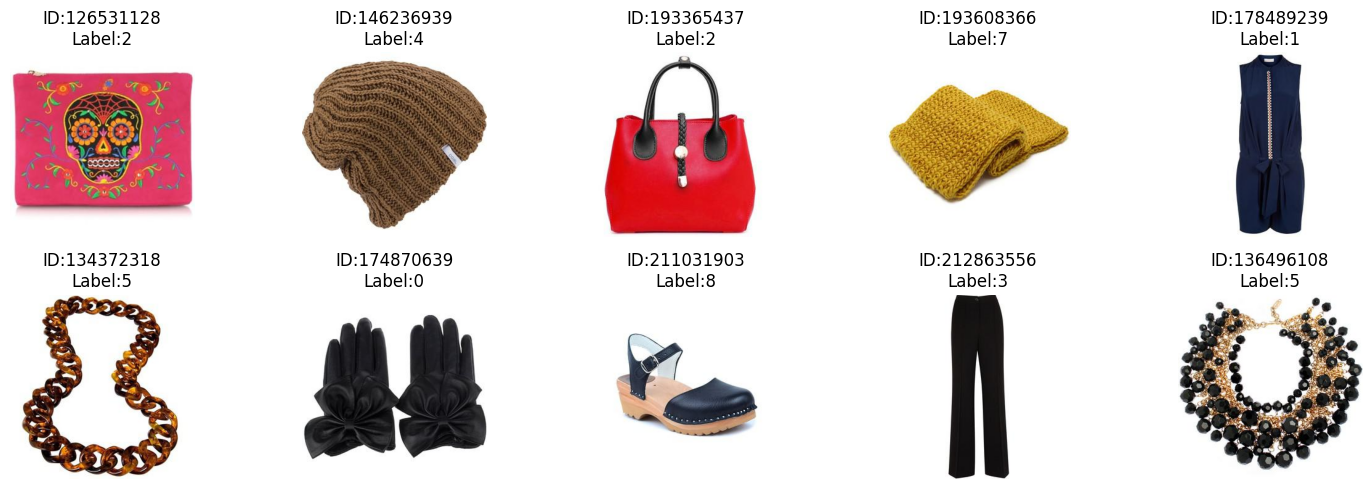

Cosine similarity giữa 10 ảnh:


,126531128,146236939,193365437,193608366,178489239,134372318,174870639,211031903,212863556,136496108
126531128,1.000,-0.020,0.930,0.333,-0.147,-0.118,0.277,-0.390,0.010,-0.043
146236939,-0.020,1.000,-0.075,0.772,-0.187,-0.251,-0.106,-0.221,-0.136,-0.226
193365437,0.930,-0.075,1.000,0.292,-0.220,0.009,0.088,-0.312,-0.156,0.127
193608366,0.333,0.772,0.292,1.000,-0.366,-0.262,-0.004,-0.156,-0.237,-0.262
178489239,-0.147,-0.187,-0.220,-0.366,1.000,-0.090,-0.121,0.086,0.013,-0.071
134372318,-0.118,-0.251,0.009,-0.262,-0.090,1.000,0.246,-0.337,-0.130,0.955
174870639,0.277,-0.106,0.088,-0.004,-0.121,0.246,1.000,-0.095,-0.207,0.017
211031903,-0.390,-0.221,-0.312,-0.156,0.086,-0.337,-0.095,1.000,-0.166,-0.385
212863556,0.010,-0.136,-0.156,-0.237,0.013,-0.130,-0.207,-0.166,1.000,-0.018
136496108,-0.043,-0.226,0.127,-0.262,-0.071,0.955,0.017,-0.385,-0.018,1.000


In [ ]:
# Test cell 9 - sửa để hiển thị ảnh + metadata + cosine similarity

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics.pairwise import cosine_similarity
import os

# --- Sample 10 ảnh ---
full_ds = FashionCategoryDataset(IMAGES_DIR, item_metadata, cat2idx, transform=val_transform)
sample_idxs = random.sample(range(len(full_ds)), 10)
sample_subset = Subset(full_ds, sample_idxs)
loader = DataLoader(sample_subset, batch_size=10, shuffle=False, num_workers=2)

model.eval()
emb_list = []
ids_list = []
labels_list = []
with torch.no_grad():
    for batch in loader:
        ids, imgs, labels = batch
        imgs = imgs.to(device)
        emb, _ = model(imgs)
        emb = emb.cpu().numpy()
        emb_list.append(emb)
        ids_list.extend(ids)
        labels_list.extend(labels.numpy())
embs = np.vstack(emb_list)

# --- Cosine similarity ---
cos_sim = cosine_similarity(embs)

# --- In thông tin metadata ---
metadata_sample = [item_metadata[iid] for iid in ids_list]  # giả sử item_metadata lưu dict
df_meta = pd.DataFrame(metadata_sample)
df_meta['id'] = ids_list
df_meta['label'] = labels_list
print("Metadata của 10 ảnh sample:")
display(df_meta)

# --- Vẽ ảnh kèm ID + label ---
plt.figure(figsize=(15,5))
for i, item_id in enumerate(ids_list):
    # Tạo path tới ảnh dựa trên item_id
    img_path = os.path.join(IMAGES_DIR, f"{item_id}.jpg")  # sửa theo extension thực tế nếu không phải .jpg
    img = plt.imread(img_path)
    plt.subplot(2, 5, i+1)
    plt.imshow(img)
    plt.axis('off')
    plt.title(f"ID:{item_id}\nLabel:{labels_list[i]}")
plt.tight_layout()
plt.show()

# --- In ma trận cosine similarity ---
print("Cosine similarity giữa 10 ảnh:")
cos_sim_rounded = np.round(cos_sim, 3)
df_cos = pd.DataFrame(cos_sim_rounded, index=ids_list, columns=ids_list)
display(df_cos)


Chạy cell 10 để encode toàn bộ dataset, lưu theo phần emb_chunks/embeddings_part_{i}.pkl (mỗi phần chứa chunk_size items) để tránh OOM.

In [ ]:
# ========== CELL 10 - FULL DATASET EMBEDDING EXTRACTION (CHUNKED) ==========
OUT_DIR = "/content/emb_chunks"
os.makedirs(OUT_DIR, exist_ok=True)
BATCH_SIZE = 64        # chỉnh nếu OOM
NUM_WORKERS = 2
CHUNK_SIZE = 50000     # số items lưu 1 file, chỉnh nhỏ nếu muốn

full_dataset = FashionCategoryDataset(IMAGES_DIR, item_metadata, cat2idx, transform=val_transform)
loader = DataLoader(full_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

model.eval()
model.to(device)

chunk = {}
count = 0
file_idx = 0
start = time.time()
with torch.no_grad():
    for batch in tqdm(loader, desc="Encoding all images"):
        ids, imgs, _ = batch
        imgs = imgs.to(device)
        emb, _ = model(imgs)    # (B,512)
        emb_np = emb.cpu().numpy()
        for iid, v in zip(ids, emb_np):
            chunk[iid] = v.astype(np.float32).tolist()
            count += 1
            if count % CHUNK_SIZE == 0:
                out_path = os.path.join(OUT_DIR, f"embeddings_part_{file_idx}.pkl")
                with open(out_path, "wb") as f:
                    pickle.dump(chunk, f)
                print("Saved", out_path, "items saved so far:", count)
                file_idx += 1
                chunk = {}
# save remainder
if len(chunk) > 0:
    out_path = os.path.join(OUT_DIR, f"embeddings_part_{file_idx}.pkl")
    with open(out_path, "wb") as f:
        pickle.dump(chunk, f)
    print("Saved final chunk", out_path)

elapsed = (time.time() - start)/60
print(f"Done. Total items encoded: {count}. Time (min): {elapsed:.2f}. Files in {OUT_DIR}")


Encoding all images:  20%|█▉        | 781/3922 [04:08<12:37,  4.15it/s]

Saved /content/emb_chunks/embeddings_part_0.pkl items saved so far: 50000


Encoding all images:  40%|███▉      | 1562/3922 [08:18<10:33,  3.73it/s]

Saved /content/emb_chunks/embeddings_part_1.pkl items saved so far: 100000


Encoding all images:  60%|█████▉    | 2344/3922 [12:18<36:07,  1.37s/it]

Saved /content/emb_chunks/embeddings_part_2.pkl items saved so far: 150000


Encoding all images:  80%|███████▉  | 3125/3922 [16:15<28:37,  2.16s/it]

Saved /content/emb_chunks/embeddings_part_3.pkl items saved so far: 200000


Encoding all images: 100%|█████████▉| 3907/3922 [20:40<00:12,  1.20it/s]

Saved /content/emb_chunks/embeddings_part_4.pkl items saved so far: 250000


Encoding all images: 100%|██████████| 3922/3922 [20:44<00:00,  3.15it/s]


Saved final chunk /content/emb_chunks/embeddings_part_5.pkl
Done. Total items encoded: 251008. Time (min): 20.74. Files in /content/emb_chunks


In [ ]:
import pickle
import os

OUT_DIR = "/content/emb_chunks"
all_files = sorted([f for f in os.listdir(OUT_DIR) if f.startswith("embeddings_part") and f.endswith(".pkl")])

# Ghép tất cả chunk
all_embeddings = {}
for f in all_files:
    path = os.path.join(OUT_DIR, f)
    with open(path, "rb") as fin:
        chunk = pickle.load(fin)
        all_embeddings.update(chunk)
print("Total items in merged dict:", len(all_embeddings))

# Lưu ra 1 file duy nhất
merged_path = "/content/embeddings_all.pkl"
with open(merged_path, "wb") as fout:
    pickle.dump(all_embeddings, fout)
print("Saved merged embeddings:", merged_path)
from google.colab import files
files.download(merged_path)


Total items in merged dict: 251008
Saved merged embeddings: /content/embeddings_all.pkl


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pickle
import os

# Chọn file thử
chunk_path = "/content/emb_chunks/embeddings_part_0.pkl"

with open(chunk_path, "rb") as f:
    chunk = pickle.load(f)

print("Số items trong chunk:", len(chunk))

# In 5 item đầu
for i, (item_id, emb) in enumerate(chunk.items()):
    print(f"{i+1}. ID: {item_id}, embedding length: {len(emb)}")
    print("   first 5 dims:", emb[:5])
    if i >= 4:  # chỉ in 5 item
        break


Số items trong chunk: 50000
1. ID: 211990161, embedding length: 512
   first 5 dims: [0.016494572162628174, 0.04339366406202316, -0.020453007891774178, -0.01155371405184269, -0.004932662006467581]
2. ID: 183179503, embedding length: 512
   first 5 dims: [-0.03052501752972603, -0.059932440519332886, -0.04324837401509285, -0.03054819069802761, -0.017620794475078583]
3. ID: 152771755, embedding length: 512
   first 5 dims: [0.07443855702877045, 0.02475852519273758, 0.05009426921606064, 0.0765506774187088, 0.040557678788900375]
4. ID: 190445143, embedding length: 512
   first 5 dims: [-0.02392910048365593, -0.06283890455961227, -0.04180217534303665, -0.03075682930648327, -0.023317670449614525]
5. ID: 211444470, embedding length: 512
   first 5 dims: [-0.026832543313503265, -0.05855994671583176, -0.04579572752118111, -0.04145631939172745, -0.0023553981445729733]


Tóm tắt logic end-to-end

1. Client gửi ảnh đến /encode/image.

2. Server nhận file → mở ảnh → chuyển thành tensor.

3. Model ResNet50 fine-tune chạy inference → xuất embedding 512-dim.

4. Trả embedding về client dưới dạng JSON.

Mục đích: biến một ảnh bất kỳ thành vector embedding, dùng cho:

- So sánh cosine similarity giữa ảnh (tìm ảnh giống / phối hợp).

- Làm tìm kiếm hình ảnh (visual search).

BE

In [ ]:
# ========== fastapi_encode.py ==========
from fastapi import FastAPI, File, UploadFile
from fastapi.responses import JSONResponse
from PIL import Image
import io, torch
from torchvision import models, transforms
import torch.nn as nn
import torch.nn.functional as F
import os

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
CKPT_PATH = "checkpoints/resnet50_proj512_best.pt"

# ====== Define FineTuneModel without classifier ======
class FineTuneModel(nn.Module):
    def __init__(self, backbone, out_dim=512):
        super().__init__()
        self.backbone = backbone
        self.proj = nn.Linear(2048, out_dim)

    def forward(self, x):
        x = self.backbone(x)           # (B,2048,1,1)
        x = x.view(x.size(0), -1)      # (B,2048)
        emb = self.proj(x)             # (B,out_dim)
        emb = F.normalize(emb, p=2, dim=1)
        return emb

# ====== Build backbone ======
resnet = models.resnet50(pretrained=False)
modules = list(resnet.children())[:-1]  # giữ đến avgpool
backbone = nn.Sequential(*modules)

# ====== Load model ======
model = FineTuneModel(backbone, out_dim=512).to(DEVICE)
state_dict = torch.load(CKPT_PATH, map_location=DEVICE)

# Chỉ lấy những key thuộc backbone/proj, bỏ classifier nếu có
filtered_state = {k.replace("backbone.", "backbone.").replace("proj.", "proj."): v
                  for k, v in state_dict.items() if "backbone" in k or "proj" in k}

model.load_state_dict(filtered_state, strict=False)
model.eval()

# ====== Transform ======
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])
])

# ====== FastAPI app ======
app = FastAPI(title="Fashion Embedding API")

@app.post("/encode/image")
async def encode_image(file: UploadFile = File(...)):
    img_bytes = await file.read()
    image = Image.open(io.BytesIO(img_bytes)).convert("RGB")
    tensor = transform(image).unsqueeze(0).to(DEVICE)
    with torch.no_grad():
        emb = model(tensor)
        vec = emb.squeeze(0).cpu().numpy().tolist()
    return JSONResponse({"embedding_vector": vec})


# DEMO

In [ ]:
# ========== CELL A: TẢI EMBEDDING & CHUẨN BỊ FAISS ==========
import pickle
import json
import numpy as np
import faiss
from tqdm import tqdm
import os

# Cấu hình đường dẫn
EMBEDDING_FILE = "embeddings_part_2.pkl"
METADATA_PATH = os.path.join("polyvore_outfits", "polyvore_item_metadata.json")
IMAGES_DIR = os.path.join("polyvore_outfits", "images")

# --- 1. Tải Embeddings và Metadata ---
try:
    with open(EMBEDDING_FILE, 'rb') as f:
        embeddings_dict = pickle.load(f)
except FileNotFoundError:
    print(f"LỖI: Không tìm thấy file {EMBEDDING_FILE}. Vui lòng kiểm tra lại đường dẫn.")
    # Sử dụng dữ liệu mẫu từ kết quả đọc pkl để code vẫn chạy (nếu cần)
    embeddings_dict = {'145672812': [0.0423, 0.0423, 0.0538, -0.0285, -0.0508],
                       '172896203': [-0.0014, -0.0330, -0.0475, 0.0534, -0.0218]} # Dữ liệu placeholder

with open(METADATA_PATH, 'r') as f:
    item_metadata = json.load(f)

print(f"Loaded {len(embeddings_dict)} embeddings.")

# --- 2. Chuẩn bị dữ liệu cho FAISS ---
all_ids = list(embeddings_dict.keys())
# Chuyển dictionary sang numpy array
all_embs = np.stack([np.array(embeddings_dict[i], dtype=np.float32) for i in all_ids])
dim = all_embs.shape[1]

# --- 3. Xây dựng Index FAISS ---
faiss.normalize_L2(all_embs)  # Chuẩn hóa để tính Cosine Similarity (Inner Product)
index = faiss.IndexFlatIP(dim)
index.add(all_embs)

print(f"FAISS Index (Dim={dim}) đã được tạo với {len(all_ids)} vector.")

Loaded 50000 embeddings.
FAISS Index (Dim=512) đã được tạo với 50000 vector.


Cell B này minh họa trực tiếp Visual Search (Tìm ảnh tương tự) bằng cách lấy một Item ngẫu nhiên làm Query và dùng FAISS để tìm các Item gần nhất.

Query Item: 185861624


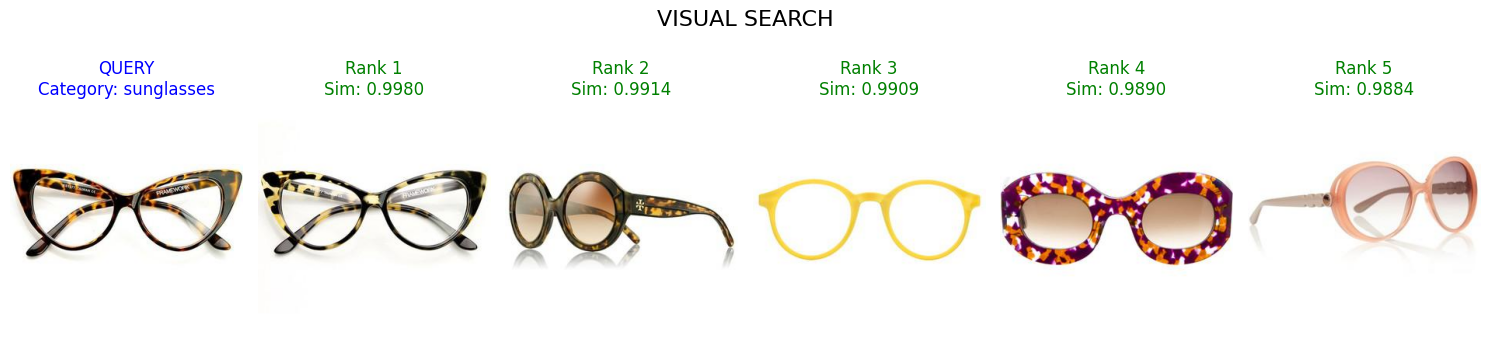

In [ ]:
# ========== CELL B: VISUAL SEARCH (TÌM ẢNH TƯƠNG TỰ) ==========
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

# --- 1. Hàm tìm kiếm ---
def find_nearest_neighbors(query_id, k=6):
    try:
        query_idx = all_ids.index(query_id)
    except ValueError:
        print(f"LỖI: ID {query_id} không có trong tập embeddings.")
        return [], []

    query_emb = all_embs[query_idx:query_idx+1]

    # Tìm kiếm trên FAISS (search_k = k + 1 vì item query nằm trong kết quả)
    D, I = index.search(query_emb, k + 1)

    # Lấy IDs và điểm số (loại bỏ item query đầu tiên)
    nearest_ids = [all_ids[idx] for idx in I[0][1:]]
    scores = D[0][1:]
    return nearest_ids, scores

# --- 2. Chọn Query Item ngẫu nhiên ---
import random
query_id = random.choice(all_ids)

# --- 3. Thực hiện tìm kiếm ---
nearest_ids, scores = find_nearest_neighbors(query_id, k=5)
all_display_ids = [query_id] + nearest_ids

print(f"Query Item: {query_id}")

# --- 4. Trực quan hóa kết quả ---
plt.figure(figsize=(15, 4))

for i, item_id in enumerate(all_display_ids):
    img_path = os.path.join(IMAGES_DIR, f"{item_id}.jpg")
    try:
        img = Image.open(img_path).convert('RGB')
    except FileNotFoundError:
        print(f"Warning: Image for {item_id} not found.")
        continue

    plt.subplot(1, len(all_display_ids), i + 1)
    plt.imshow(img)
    plt.axis('off')

    if i == 0:
        cat = item_metadata.get(item_id, {}).get('semantic_category', 'N/A')
        plt.title(f"QUERY\nCategory: {cat}", color='blue')
    else:
        score = scores[i - 1]
        plt.title(f"Rank {i}\nSim: {score:.4f}", color='green')

plt.suptitle("VISUAL SEARCH", fontsize=16)
plt.tight_layout()
plt.show()

Running T-SNE on 2000 samples...


/usr/local/lib/python3.12/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


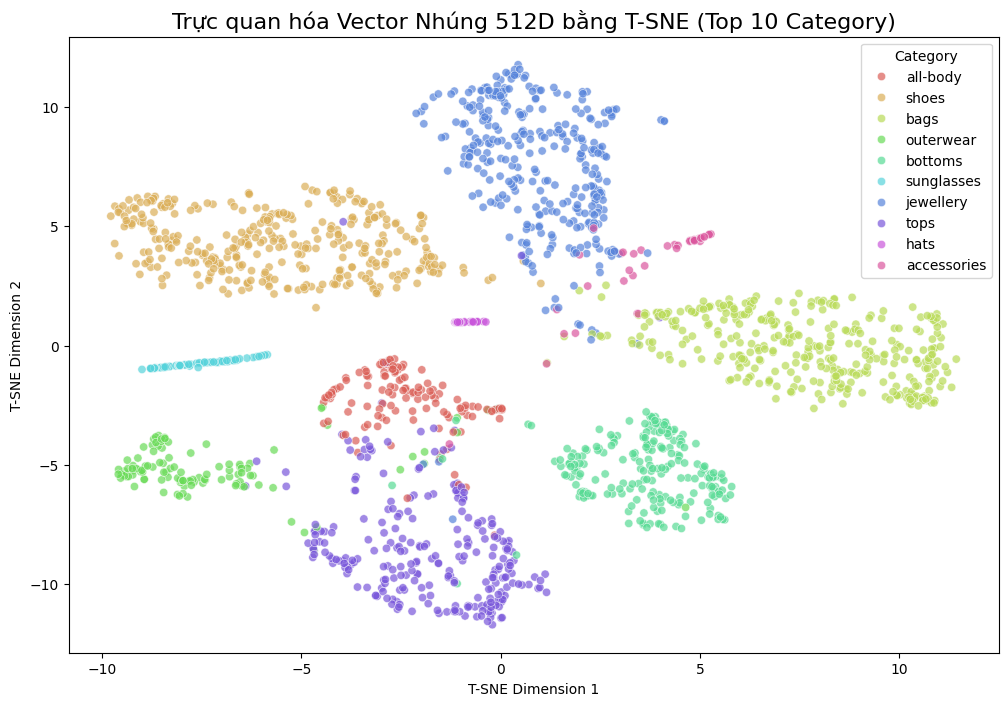


Nhận xét TSNE: Các Category cùng loại (ví dụ: 'tops', 'dresses') có xu hướng tạo thành các cụm gần nhau.


In [ ]:
# ========== CELL C: TRỰC QUAN HÓA KHÔNG GIAN EMBEDDING (TSNE) ==========
from sklearn.manifold import TSNE
import pandas as pd
import seaborn as sns

# --- 1. Lấy mẫu dữ liệu (Sample) ---
# Lấy mẫu 2000 vector để TSNE chạy nhanh
SAMPLE_SIZE = 2000
if len(all_embs) > SAMPLE_SIZE:
    sample_indices = np.random.choice(len(all_embs), SAMPLE_SIZE, replace=False)
    embs_sample = all_embs[sample_indices]
    ids_sample = [all_ids[i] for i in sample_indices]
else:
    embs_sample = all_embs
    ids_sample = all_ids

# --- 2. Giảm chiều bằng T-SNE ---
print(f"Running T-SNE on {len(embs_sample)} samples...")
# Thường cần thời gian để TSNE hội tụ
tsne = TSNE(n_components=2, random_state=42, perplexity=30, n_iter=300)
embs_2d = tsne.fit_transform(embs_sample)

# --- 3. Chuẩn bị DataFrame cho Trực quan hóa ---
df_tsne = pd.DataFrame(embs_2d, columns=['Dim 1', 'Dim 2'])
df_tsne['Item ID'] = ids_sample
df_tsne['Category'] = [item_metadata.get(i, {}).get('semantic_category', 'Unknown') for i in ids_sample]

# Lọc Top N Category phổ biến nhất để trực quan dễ hơn
top_cats = df_tsne['Category'].value_counts().nlargest(10).index
df_plot = df_tsne[df_tsne['Category'].isin(top_cats)]

# --- 4. Vẽ đồ thị ---
plt.figure(figsize=(12, 8))
sns.scatterplot(
    x='Dim 1', y='Dim 2',
    hue='Category',
    data=df_plot,
    palette=sns.color_palette("hls", df_plot['Category'].nunique()),
    legend="full",
    alpha=0.7
)

plt.title("Trực quan hóa Vector Nhúng 512D bằng T-SNE (Top 10 Category)", fontsize=16)
plt.xlabel("T-SNE Dimension 1")
plt.ylabel("T-SNE Dimension 2")
plt.show()

print("\nNhận xét TSNE: Các Category cùng loại (ví dụ: 'tops', 'dresses') có xu hướng tạo thành các cụm gần nhau.")

QUERY: 201811447 (Category: hats)


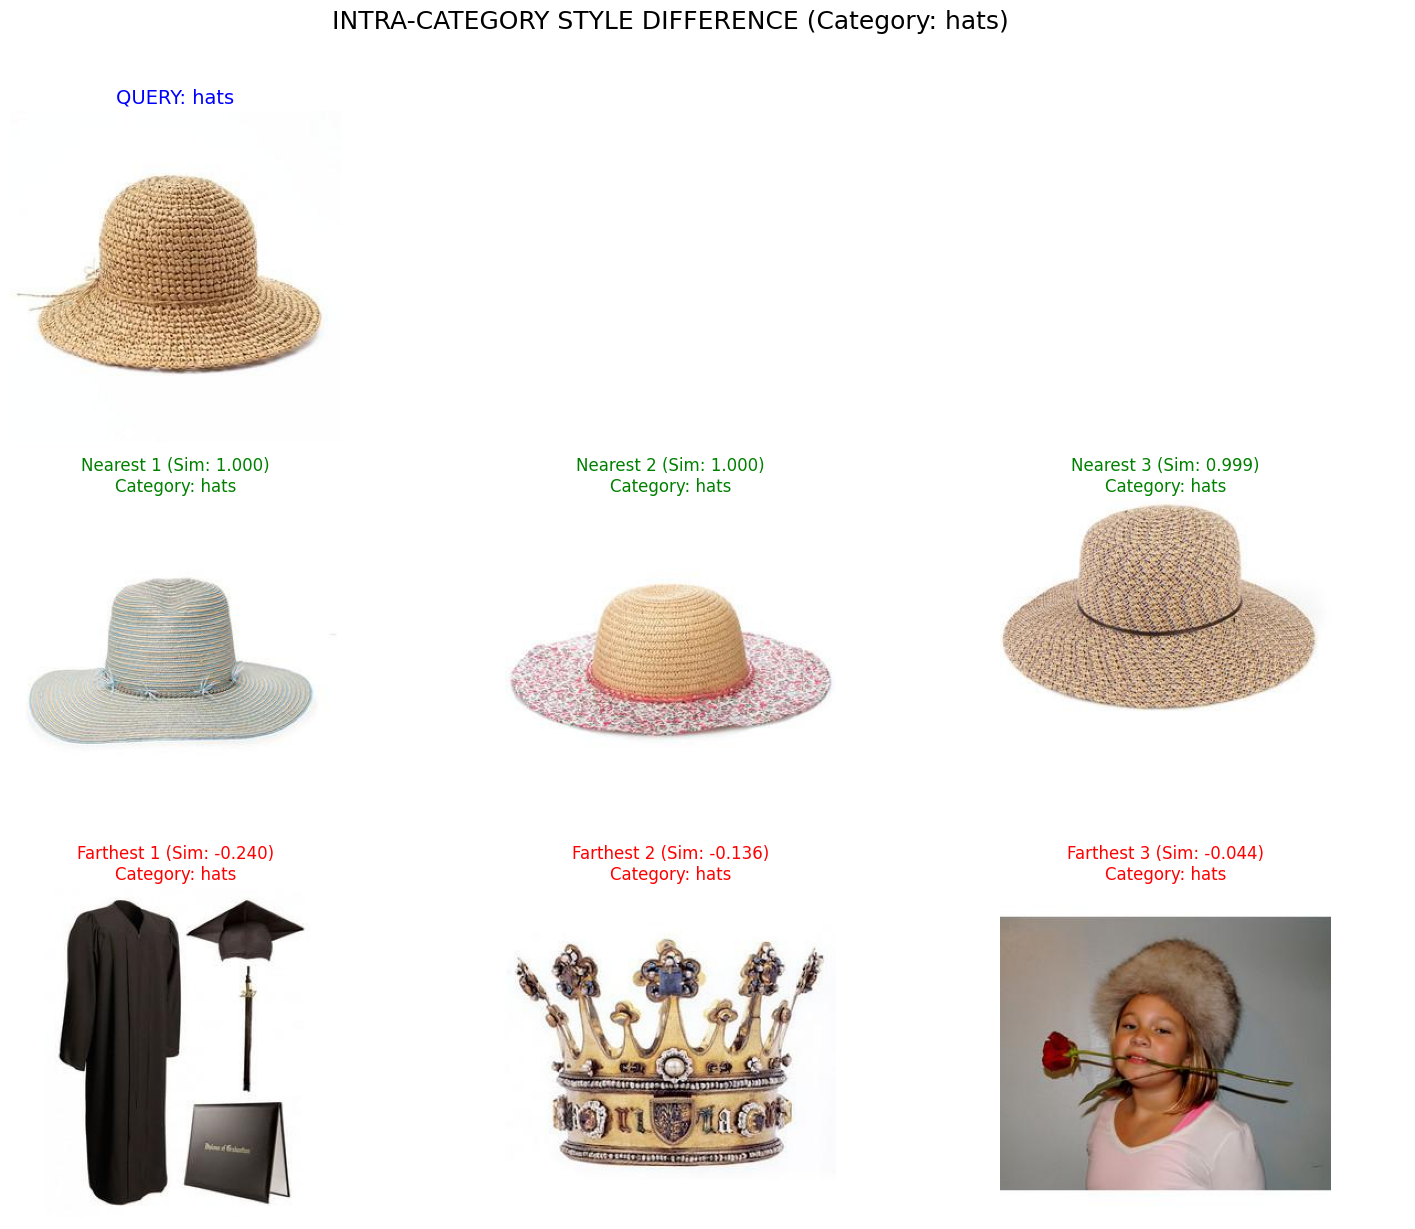

In [ ]:
# ========== CELL G: INTRA-CATEGORY STYLE DIFFERENCE CHECK (TARGETING HATS) ==========

import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os

# --- FIX: Initialize all_categories ---
# Biến này cần được tạo lại dựa trên all_ids và item_metadata
all_categories = np.array([item_metadata.get(i, {}).get('semantic_category', 'Unknown') for i in all_ids])
# ------------------------------------

# --- 1. Select Query Item: Target Category "hats" ---
TARGET_CATEGORY = 'hats'
valid_hat_ids = [i for i in all_ids if item_metadata.get(i, {}).get('semantic_category', 'Unknown') == TARGET_CATEGORY]

if len(valid_hat_ids) < 30:
    # Nếu không đủ 30 Item 'hats', mô hình sẽ chọn ngẫu nhiên các category khác.
    # Ta phải giữ logic random ban đầu nhưng nếu có đủ, ta ưu tiên hats.
    print(f"Warning: Only {len(valid_hat_ids)} items found in 'hats'. Using random category if insufficient.")
    query_id = random.choice(all_ids)
else:
    # Chọn Item ngẫu nhiên từ Category 'hats'
    query_id = random.choice(valid_hat_ids)

query_cat = item_metadata.get(query_id, {}).get('semantic_category', 'Unknown')

# --- Đảm bảo Item được chọn có số lượng lớn (Áp dụng lại logic while) ---
while query_cat == 'Unknown' or all_categories.tolist().count(query_cat) < 30:
    query_id = random.choice(all_ids)
    query_cat = item_metadata.get(query_id, {}).get('semantic_category', 'Unknown')

print(f"QUERY: {query_id} (Category: {query_cat})")

# --- 2. Build Same-Category Candidate Set ---
# Đảm bảo các ứng viên đều cùng Category với Query Item
same_cat_ids = [i for i in all_ids if item_metadata.get(i, {}).get('semantic_category', 'Unknown') == query_cat and i != query_id]

if len(same_cat_ids) < 6:
    print("Not enough items in this category for comparison (min 6 required).")
    exit() # Thoát nếu không đủ để so sánh

# --- 3. Compute Cosine Similarity against candidates ---
query_emb = np.array(embeddings_dict[query_id], dtype=np.float32).reshape(1, -1)
candidate_embs = np.stack([np.array(embeddings_dict[i], dtype=np.float32) for i in same_cat_ids])

# Tính Cosine Similarity
cosine_scores = cosine_similarity(query_emb, candidate_embs)[0]

# --- 4. Sort and Select ---
# Sort ascending (farthest first)
sorted_indices = np.argsort(cosine_scores)

# 3 Most Similar Items (highest scores)
nearest_indices = sorted_indices[-3:][::-1]
nearest_ids = [same_cat_ids[i] for i in nearest_indices]
nearest_scores = cosine_scores[nearest_indices]

# 3 Most Dissimilar Items (lowest scores)
farthest_indices = sorted_indices[:3]
farthest_ids = [same_cat_ids[i] for i in farthest_indices]
farthest_scores = cosine_scores[farthest_indices]

# --- 5. Visualization ---
TITLE_FONT_SIZE = 18
ITEM_FONT_SIZE = 12

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
plt.suptitle(f"INTRA-CATEGORY STYLE DIFFERENCE (Category: {query_cat})",
             fontsize=TITLE_FONT_SIZE,
             y=1.02)

# Hàm vẽ Item đã được điều chỉnh để chấp nhận 2 dòng tiêu đề
def plot_item(ax, item_id, title_line1, title_line2, color):
    img_path = os.path.join(IMAGES_DIR, f"{item_id}.jpg")
    try:
        img = Image.open(img_path).convert('RGB')
        ax.imshow(img)
        # Combine two title lines
        full_title = f"{title_line1}\n{title_line2}"
        ax.set_title(full_title, color=color, fontsize=ITEM_FONT_SIZE)
    except FileNotFoundError:
        ax.text(0.5, 0.5, "Image Not Found", ha='center', fontsize=ITEM_FONT_SIZE)
    ax.axis('off')

# Row 0: Query (position (0,0))
ax = axes[0, 0]
img_path = os.path.join(IMAGES_DIR, f"{query_id}.jpg")
img = Image.open(img_path).convert('RGB')
ax.imshow(img)
ax.set_title(f"QUERY: {query_cat}", color='blue', fontsize=ITEM_FONT_SIZE + 2)
ax.axis('off')

# Row 1: Nearest (MOST SIMILAR)
plot_item(axes[1, 0], nearest_ids[0], f"Nearest 1 (Sim: {nearest_scores[0]:.3f})", f"Category: {query_cat}", "green")
plot_item(axes[1, 1], nearest_ids[1], f"Nearest 2 (Sim: {nearest_scores[1]:.3f})", f"Category: {query_cat}", "green")
plot_item(axes[1, 2], nearest_ids[2], f"Nearest 3 (Sim: {nearest_scores[2]:.3f})", f"Category: {query_cat}", "green")

# Row 2: Farthest (MOST DISSIMILAR)
plot_item(axes[2, 0], farthest_ids[0], f"Farthest 1 (Sim: {farthest_scores[0]:.3f})", f"Category: {query_cat}", "red")
plot_item(axes[2, 1], farthest_ids[1], f"Farthest 2 (Sim: {farthest_scores[1]:.3f})", f"Category: {query_cat}", "red")
plot_item(axes[2, 2], farthest_ids[2], f"Farthest 3 (Sim: {farthest_scores[2]:.3f})", f"Category: {query_cat}", "red")


# Remove unused subplots
axes[0, 1].axis('off')
axes[0, 2].axis('off')

plt.tight_layout()
plt.show()

Biểu đồ này là cách tốt nhất để chứng minh rằng quá trình Fine-Tuning giám sát đã hoạt động hiệu quả. Nó cho thấy các Item cùng Category (nhãn) đã được kéo lại gần nhau trong không gian embedding.

QUERY ITEM (FIXED): 201811447 (Category: hats)


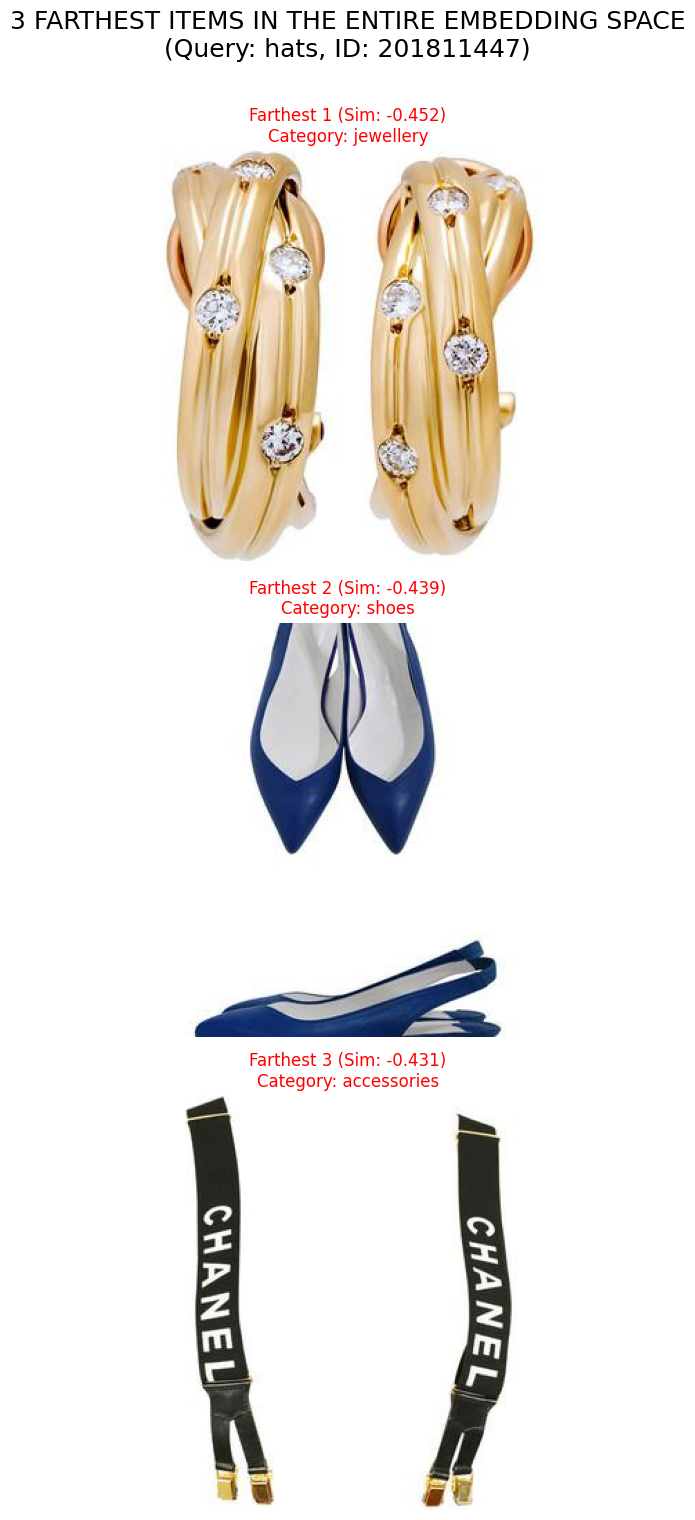

In [ ]:
# ========== CELL H: TÌM 3 ITEM XA NHẤT TRÊN TOÀN BỘ DATASET (KHUNG DỌC - CHỈ FARTHEST) ==========
# Code này sử dụng ID cố định: 201811447 để kiểm tra toàn bộ không gian embedding.

import random
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
import os

# --- Cấu hình Truy vấn Cố định ---
FIXED_QUERY_ID = '201811447'
query_id = FIXED_QUERY_ID
query_cat = item_metadata.get(query_id, {}).get('semantic_category', 'Unknown')
print(f"QUERY ITEM (FIXED): {query_id} (Category: {query_cat})")

# --- 1. Tính toán Tương đồng với TẤT CẢ Items (Không lọc Category) ---
query_emb = np.array(embeddings_dict[query_id], dtype=np.float32).reshape(1, -1)
all_candidate_ids = [i for i in all_ids if i != query_id]
all_candidate_embs = np.stack([np.array(embeddings_dict[i], dtype=np.float32) for i in all_candidate_ids])

# Tính Cosine Similarity trên toàn bộ tập ứng viên
all_cosine_scores = cosine_similarity(query_emb, all_candidate_embs)[0]

# --- 2. Sắp xếp và Lựa chọn ---
# Sắp xếp tăng dần điểm Cosine (Item xa nhất sẽ nằm ở đầu)
all_sorted_indices = np.argsort(all_cosine_scores)

# 3 Item KHÁC BIỆT NHẤT (lowest scores - lấy 3 mục đầu tiên)
farthest_indices = all_sorted_indices[:3]
farthest_ids = [all_candidate_ids[i] for i in farthest_indices]
farthest_scores = all_cosine_scores[farthest_indices]
farthest_categories = [item_metadata.get(iid, {}).get('semantic_category', 'N/A') for iid in farthest_ids]


# --- 3. Trực quan hóa ---
TITLE_FONT_SIZE = 18
ITEM_FONT_SIZE = 12

N_DISPLAY_ITEMS = 3 # Chỉ hiển thị 3 Farthest items
fig, axes = plt.subplots(N_DISPLAY_ITEMS, 1, figsize=(6, 5 * N_DISPLAY_ITEMS)) # Lưới N_DISPLAY_ITEMS hàng x 1 cột

plt.suptitle(f"3 FARTHEST ITEMS IN THE ENTIRE EMBEDDING SPACE\n(Query: {query_cat}, ID: {query_id})",
             fontsize=TITLE_FONT_SIZE, y=1.01) # Điều chỉnh y để tiêu đề không che hình

# Hàm vẽ Item
def plot_item(ax, item_id, title_line1, title_line2, color):
    img_path = os.path.join(IMAGES_DIR, f"{item_id}.jpg")
    try:
        img = Image.open(img_path).convert('RGB')
        ax.imshow(img)
        full_title = f"{title_line1}\n{title_line2}"
        ax.set_title(full_title, color=color, fontsize=ITEM_FONT_SIZE)
    except FileNotFoundError:
        ax.text(0.5, 0.5, "Image Not Found", ha='center', fontsize=ITEM_FONT_SIZE)
    ax.axis('off')

# Hàng 0-2: FARTHEST ITEMS
for i in range(N_DISPLAY_ITEMS):
    plot_item(axes[i], farthest_ids[i],
              f"Farthest {i+1} (Sim: {farthest_scores[i]:.3f})",
              f"Category: {farthest_categories[i]}",
              "red")

plt.tight_layout()
plt.show()